<a href="https://colab.research.google.com/github/blongho/machine-learning/blob/master/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Pipelines and ensemble models

This lab will cover various ensemble learning methods covered in the lectures, such as boosting, bagging, and stacking, together with the scikit-learn pipeline. We will tackle the fetal health classification problem using random forest and XGBoost for better performances. We will also learn how to integrate preprocessing and training processes into one pipeline to re-use the whole process easier. The objective of this lab is to get a concept of a whole machine learning pipeline from feature engineering to model selection and lead to a final model.

This lab will mainly focus on:
- Learn how to use the basic random forest, Adaboost, and XGBoost.
- Learn how to use grid search (recap on DAMI) and randomized search.
- Learn how to use the scikit-learn pipeline to construct a complete and reusable preprocessing cycle.

This lab has the following tasks:

- Add private functions to the pipeline.
- Integrate a grid search to the pipeline and choose the best model


Our goal is to find out the best ensemble model for our dataset. We need to split the dataset into two parts: training and validation sets. Then we test parameter options and eventually choose one best model and compare their test performance.

We will use the [fetal health classification](https://www.kaggle.com/andrewmvd/fetal-health-classification) data from Kaggle. The reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a crucial indicator of human progress. The UN expects that by 2030, countries end preventable deaths of newborns and children under five years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

Parallel to the notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost-accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions, and more.

This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetricians into three classes:

- Normal: 1
- Suspect: 2
- Pathological: 3

We will first try to apply ensemble models and eventually integrate grid search and pipeline to create an automated evaluation process to find the best model.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  #!ls "/content/drive/My Drive"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 0. Libraries

We will use the following libraries.

In [2]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import average_precision_score, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

### 1. Data exploration

Let's locate the dataset anywhere you want in your local and load it using pd.read_csv. The dataset can be downloaded [here](https://www.kaggle.com/andrewmvd/fetal-health-classification) or ilearn. This time, we will return to pandas DataFrame!

In [3]:
# Create a DataFrame
if IN_COLAB:
  data = pd.read_csv("/content/drive/My Drive/notebooks/ml/fetal_health.csv")
else:
  data  = pd.read_csv("fetal_health.csv")
data = pd.DataFrame(data)

In [4]:
# head
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


The first thing we need to do is to separate features and labels. Also, since our labels are categorical, it might be better to change the data type of labels to integers.

In [6]:
# Features
X = data[data.columns[:-1]]
# Labels
y = data[data.columns[-1:]]

In [7]:
X.head

<bound method NDFrame.head of       baseline value  accelerations  ...  histogram_variance  histogram_tendency
0              120.0          0.000  ...                73.0                 1.0
1              132.0          0.006  ...                12.0                 0.0
2              133.0          0.003  ...                13.0                 0.0
3              134.0          0.003  ...                13.0                 1.0
4              132.0          0.007  ...                11.0                 1.0
...              ...            ...  ...                 ...                 ...
2121           140.0          0.000  ...                 2.0                 0.0
2122           140.0          0.001  ...                 3.0                 1.0
2123           140.0          0.001  ...                 4.0                 1.0
2124           140.0          0.001  ...                 4.0                 1.0
2125           142.0          0.002  ...                 1.0                 0.

In [8]:
y.head

<bound method NDFrame.head of       fetal_health
0              2.0
1              1.0
2              1.0
3              1.0
4              1.0
...            ...
2121           2.0
2122           2.0
2123           2.0
2124           2.0
2125           1.0

[2126 rows x 1 columns]>

In [9]:
X.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


Today, our focus is to learn about ensemble methods, so we would not focus on many data exploration strategies, but let's try to investigate a few things. First, let's check if the labels are balanced or not. 

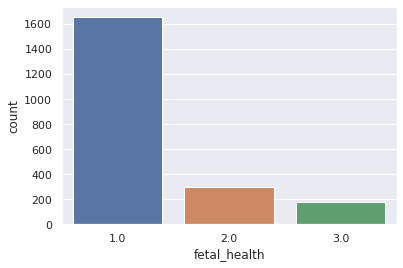

In [10]:
# countplot
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="fetal_health", data=data)

In [11]:
y.value_counts()

fetal_health
1.0             1655
2.0              295
3.0              176
dtype: int64

It is natural that the normal cases are most common. It might lead to higher accuracy too, as label 1 keeps about 78% of the whole dataset. However, to make a robust model that does not have any relationship with the distribution the dataset typically has, we may need to consider it so the model should not be biased towards the normal cases.

In [12]:
data.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [13]:
# duplicated, drop_duplicates - Duplication check
data.drop_duplicates()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


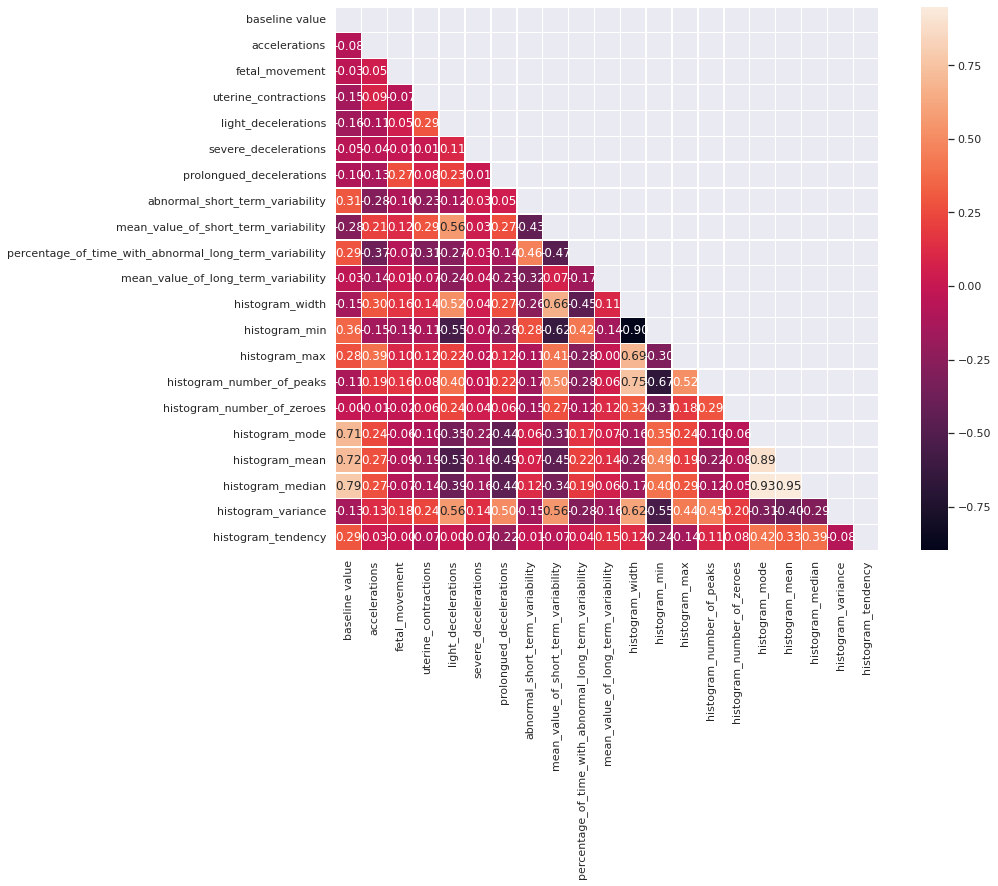

In [14]:
# Correlation check - among the features
mat = X.corr()
mask = np.triu(np.ones_like(mat, dtype=bool))
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(mat, mask=mask, annot = True, linewidths=0.5, fmt = ".2f", square=True)

We may need to apply **1) standardization** and **2) Oversampling the minority** for better performance. We might be able to apply those methods one by one, but it will be better to streamline things into one pipeline. 

(0.0, 22.0)

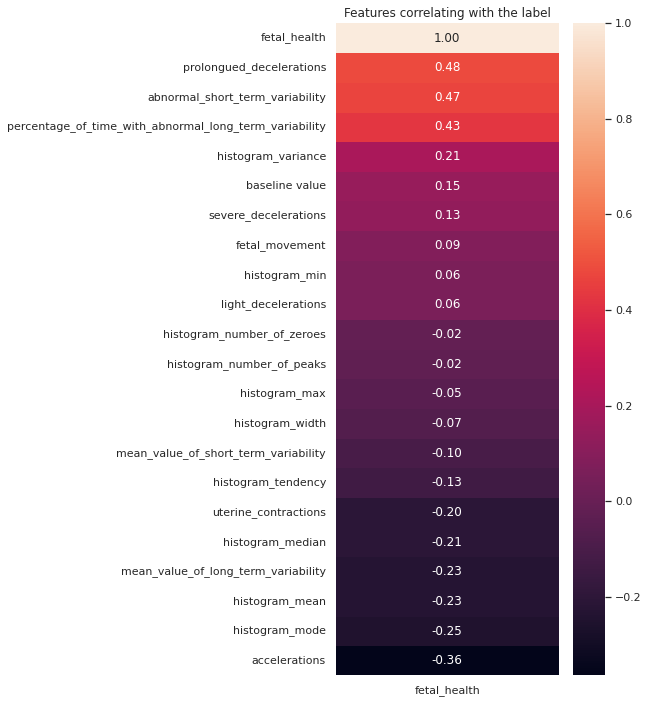

In [15]:
# Correlation check - features and the label
plt.figure(figsize=(5, 12))
heatmap = sns.heatmap(data.corr()[['fetal_health']].sort_values(by='fetal_health', ascending=True), fmt="0.2f", annot=True)
heatmap.set_title('Features correlating with the label')
heatmap.set_ylim([0,22])

### 2. Preprocessing

After dividing the dataset into multiple parts, preprocessing like standardization or over-sampling should be applied. If not, we will end up with a cheating model that already knows part of the test information.

In [16]:
# train_test_split with stratification, test size=0.3
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=42)

We can simply apply the standardization function we made in the previous lab or scikit-learn's method to standardize the dataset. This time, let's stick to scikit-learn. You can use scikit-learn's **StandardScaler** to apply standardization (= set the mean and the standard 

In [17]:
# StandardScaler
scalar = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scalar.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled,columns=X_train.columns)
X_test_scaled = scalar.fit_transform(X_test)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

In [18]:
# describe - standardized mean and standard deviation
print("Scaled trained data\n")
print(X_train_scaled.describe())
print("\n\nScaled test data")
print(X_test_scaled.describe())

Scaled trained data

       baseline value  accelerations  ...  histogram_variance  histogram_tendency
count    1.488000e+03   1.488000e+03  ...        1.488000e+03        1.488000e+03
mean    -7.981966e-16   6.849360e-17  ...        7.147807e-17        2.068238e-16
std      1.000336e+00   1.000336e+00  ...        1.000336e+00        1.000336e+00
min     -2.719876e+00  -8.332572e-01  ...       -6.485103e-01       -2.161711e+00
25%     -7.091569e-01  -8.332572e-01  ...       -5.807494e-01       -5.197374e-01
50%     -5.405159e-03  -3.219637e-01  ...       -4.113471e-01       -5.197374e-01
75%      6.983466e-01   7.006233e-01  ...        1.646208e-01        1.122236e+00
max      2.709066e+00   3.768384e+00  ...        8.465334e+00        1.122236e+00

[8 rows x 21 columns]


Scaled test data
       baseline value  accelerations  ...  histogram_variance  histogram_tendency
count    6.380000e+02   6.380000e+02  ...        6.380000e+02        6.380000e+02
mean    -1.105699e-15  -9.744904e-1

In [19]:
y.value_counts()

fetal_health
1.0             1655
2.0              295
3.0              176
dtype: int64

To over-sample the instances from the minority classes (2 and 3), we will use a new library called imblearn (which stands for Imbalanced learn). This library contains various classifiers and resampling methods for imbalanced datasets. Let's use the most straightforward method it has.

In [20]:
# RandomOverSampler
# Create X_resampled, y_resampled
# - fit_resample

In [21]:
# value_counts

Unfortunately, this simple oversampler just duplicates the instances we already have. So we can regard that it's just a weighting factor putting more weights on the minority classes.

NameError: ignored

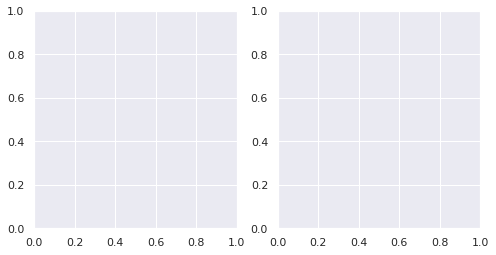

In [22]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].scatter(X_resampled.iloc[:, 0], X_resampled.iloc[:, 7], s=1)
ax[1].scatter(X_train_scaled.iloc[:, 0], X_train_scaled.iloc[:, 7], s=1)
ax[0].set_title("Resampled")
ax[1].set_title("Original")
plt.show()

There are some more advanced techniques to resample such as **SMOTE** or **ADASYN**...

In [ ]:
# SMOTE, ADASYN
# X_resampled_SMOTE, y_resampled_SMOTE

# X_resampled_ADASYN, y_resampled_ADASYN


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=[12, 4])
ax[0].scatter(X_resampled.iloc[:, 0], X_resampled.iloc[:, 7], s=2)
ax[1].scatter(X_resampled_SMOTE.iloc[:, 0], X_resampled_SMOTE.iloc[:, 7], s=2)
ax[2].scatter(X_resampled_ADASYN.iloc[:, 0], X_resampled_ADASYN.iloc[:, 7], s=2)
ax[3].scatter(X_train_scaled.iloc[:, 0], X_train_scaled.iloc[:, 7], s=2)
ax[0].set_title("Resampled_RANDOM")
ax[1].set_title("Resampled_SMOTE")
ax[2].set_title("Resampled_ADASYN")
ax[3].set_title("Original")

plt.show()

Sometimes there have been some practices to keep the minority classes at most 50% of the majority (so in our case, classes 2 and 3 won't have more than 827 instances).

### 3. Simple model - Decision Tree and Logistic Regression

Before getting into today's topic, let's recap the topic we have learned before: how to create a scikit-learn model. We will create a decision tree and logistic regression models and compare their performances.

In [ ]:
dt = DecisionTreeClassifier()
lg = LogisticRegression()
dt.fit(X_train_scaled, y_train)
lg.fit(X_train_scaled, y_train)
print(dt.score(X_test_scaled, y_test), lg.score(X_test_scaled, y_test))
print(classification_report(y_test, dt.predict(X_test_scaled)))

In [ ]:
dt.fit(X_resampled_ADASYN, y_resampled_ADASYN)
lg.fit(X_resampled_ADASYN, y_resampled_ADASYN)
print(dt.score(X_test_scaled, y_test), lg.score(X_test_scaled, y_test))
print(classification_report(y_test, dt.predict(X_test_scaled)))

Those are our basic performance scores.

### 4. Ensemble methods

We may use some ensemble methods that were covered in the lecture. To just use those models, we can still stick to the standard scikit-learn process. Random forests and AdaBoost are supported by scikit-learn. However, you need a separate library for XGBoost.

#### Random forests

In [ ]:
# RandomForestClassifier

#### AdaBoost - Various classifiers

AdaBoost is a normal boosting algorithm, creating multiple weak learners throughout multiple phases - so each phase is dependent on the previous one. Since the weight can be applied to any classifier, you can change the base classifier as you want.

In [ ]:
# AdaBoostClasifier
# - base_estimator

In [ ]:
# - base_estimator = LogisticRegression()

#### XGBoost

XGBoost is a decision-tree-based gradient boosting classifier with more advanced tricks inside to make itself a more scalable and better performance. The key differences are as follows:

 - An improved data structure for better utilization such as sparse matrices
 - Better support for multicore processing.
 - L1/L2 regularization
 - Tree-node dropout

In [ ]:
# - XGBoost

XGBoost also supports to handle imbalanced datasets by putting different weights based on the class distribution. For more details, [check this article](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).


### 5. Grid search and Randomized search

#### Grid search

Grid search is a method of tuning the optimal hyperparameter value by trying all possible combinations of the parameters of interest, provided by scikit-learn of python. Grid search has the disadvantage of being very expensive and time-consuming to calculate because it evaluates all combinations.

#### Randomized search

Randomized search finds optimal hyperparameter values by generating random numbers within a specified range. Hyperparameters are of different relative importance, and random searches are advantageous for optimization because more important parameters can be explored. In fact, there are also indicators that random searches in papers yield better results with fewer search opportunities. Random Search can stop searching at any time. This is because even if you stop in the middle, the search is not biased towards a specific range. 

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Our parameter distribution (or parameter grid in the case of grid search)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Compared to the grid search, the randomized search has some randomness and iterations, so it has a few more parameters such as **n_iter**, **random_state**. Also, the parameter grid is now called parameter distributions as it can also receive a distribution (such as **scipy.stats.uniform**) and sample from it.

In [ ]:
# RandomizedSearchCV
# - estimator
# - param_distribution
# - n_iter
# - cv
# - random_state


In [ ]:
%%time
rf_random.fit(X_train_scaled, y_train)

In [ ]:
# best_estimator

In [ ]:
# best_score

In [ ]:
# test score

You can also run a grid search and see if it completes in a reasonable amount of time.

In [ ]:
gs_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)

In [ ]:
%%time
gs_random.fit(X_train_scaled, y_train) # NEVER FINISHES!!

Randomized search is greatly helpful when we have many options to search as it randomly choose the combination. However, it does not guarantee that it will find the optimal solution, but still it will give you similar result with the grid search. However, if you only have a limited number of parameter combinations, it is still the best to apply the grid search.

### 6. Pipelines

Most machine learning data is not ideal for building a final model. Many data transformations such as manipulating categorical variables or scaling and normalization must be performed. Scikit-Learn has built-in most commonly used functions for preprocessing functions. However, in a typical machine learning workflow, you would need to apply all these transformations more than once. Because you do it once when you train the model and again for every new data you want to predict. Of course, you can use a reusable function, but you will have to run it first and then call the model separately. The Scikit-Learn pipeline is a tool that simplifies this process and has several key advantages:

- Pipelines allow you to create a single object that contains all stages of data preprocessing and classification.
- It makes cross-validation and other types of model selection easier.
- Increased reproducibility 

Using pipeline lets you manage your whole preprocessing and training process in one place and change the setting in a central place.

In [ ]:
# Create a pipeline
# - scaler = StandardScaler
# - selector = VarianceThreshold with 0.1
# - classifier = RandomForestClassifier


In [ ]:
print('Training set score: ' + str(pipe.score(X_train_scaled, y_train)))
print('Test set score: ' + str(pipe.score(X_test_scaled, y_test)))

### Task 1: Add private functions to the pipelines

Most of the functions are supported by scikit-learn, but sometimes you may need other methods as well to change the dataset. In this case, you may have some modules that are not part of the pipeline. However, the scikit-learn pipeline also supports custom functions following some rules. 

The rule here is to construct a class with both **fit** and **transform** methods inside.

- Create **SquaredFeatureTransformer** that squares the values in our DataFrame and merges those squared features into the original DataFrame. 
  - Our dataset will have two times more features after this transformation.
  - Integrate this transformer into the pipeline we made before by adding the class **SquaredFeatureTransformer** after 'scaler' with the name 'squared'. - Eventually, the pipeline should have four elements: 'scaler', 'squared', 'selector', and 'classifier'.
  - Fit the pipeline as we did before by calling **fit** method on **X_train_scaled** and **y_train_scaled**.

In [ ]:
# SquaredFeatureTransformer
# - BestEstimator, TransformerMixin
# - __init__
# - fit
# - transform

class SquaredFeatureTransformer(BaseEstimator, TransformerMixin):
  """
  This class will transform the dataset by adding squared features
  You need to change the transform function to square each feature's values and add them to the matrix.
  """
  def __init__(self):
    return None
  
  def fit(self, X, y = None):
    return None

  def transform(self, X, y = None):
    """
    Square each feature and add to the data 
    """
    return None

pipe = None # CHANGE IT

pipe.fit(X_train_scaled, y_train)

In [ ]:
print('Training set score: ' + str(pipe.score(X_train_scaled, y_train)))
print('Test set score: ' + str(pipe.score(X_test_scaled, y_test)))

### Task 2: Put things together - integrate grid search / randomized search into the pipelines under ensemble models

So far, we have learned randomized search and grid search for a parameter search of a specific model and the scikit-learn pipeline to streamline the complete machine learning task from preprocessing to model training. Then the remaining question is how we can also integrate the model selection process - like the parameter search we performed using the grid search and the randomized search - into the pipeline.

By adding those parameter tests, you can also change the modules that should be in the same name: for example, you can have [StandardScaler(), MinMaxScaler(),
  Normalizer(), MaxAbsScaler()] in a name 'scaler' of the pipeline. Moreover, you can perform a grid test if they have the common parameters - they usually have. 

Task: Define a new variable **parameters** and customize the options by creating a dictionary. You can change the pipeline values by setting the same key as you did for the pipeline. For example, if you would like to test two scalers, you can put 'scaler': [scaler1, scaler2]. 

- Create the following key-values in the **parameters** dictionary.
 - 'scaler': StandardScaler(), MinMaxScaler().
 - 'classifier': AdaBoostClassifier(), XGBoostClassifier(), RandomForestClassifier().

- You can also search for many parameter options by using '__'. If you want to test the threshold parameter of the selector (here, we use VarianceThreshold as a selector), you can specify the key as 'selector__threshold'.
  - Add 'selector__threshold' key with the values [0, 0.001, 0.01] into the **parameters** dictionary.

- Run a grid search as usual. You can put the pipeline instance (pipe) as a classifier and **parameters** as a param_grid. Check the training score and test score.

In [ ]:
pipe = None # CHANGE IT

parameters = None # CHANGE IT

grid = # CHANGE IT

pipe.fit(X_train_scaled, y_train)

In [ ]:
print('Training set score: ' + str(grid.score(X_train_scaled, y_train)))
print('Test set score: ' + str(grid.score(X_test_scaled, y_test)))